# Question and Explanation of Notebook

As we read through current events from various news sources, we see that facts, political figures, and events are often represented in a multitude of ways. The context of these reportings influences the way we see what's happening in the world around us.

The purpose of this notebook is to provide insight on the following question: "Do media sources of different biases have different contexts for their usage of the same words? If so, can we identify any relationships between contexts of "interesting" words with regards to their media bias? How about with regards to each other (i.e. context map)?

In an effort to answer this question, I have proposed a way to operationally define what "interesting words" are and how to measure them. There will be 3 forms of interesting words, defined below: 

1. Words that are popular among a certain media_source. We’ll outlink from a particular media source and find larger trends.

2. Words that are frequently used(repeated) in particular stories of a media source. We'll outlink from an article and find smaller, more localized trends.

3. Random interesting words that I defined for the sake of curiosity. (More for interest to see if we can uncover anything). 

The numbers in the list above will be referred to throughout the notebook as a legend in a paranthesized form [ ex. (1) ] for which process words we are discovering or using.

## Initializing Sources

In [1]:
%matplotlib inline

import mediacloud
import os
import json
import csv
import requests
import operator
import matplotlib.pyplot as plt
import collections
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/Users/Nani/anaconda3/lib/python3.4/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
MY_API_KEY = '0b048304d2f7398cb91248b7e07b3b153d32840c1a8c42ab4006f58aaa8a440a'

 We have a list of 5 media sources for each bias and reporting accuracy combination defined below.

In [3]:
left_media = ["New York Times", "NPR", "Politico", "CNN", "American Civil Liberties Union"]
left_fake_media = ["If You Only News", "Occupy Democrats", "FWD Now", "Jezebel", "Blue Tribune"]
right_media = ["Fox News", "Daily Telegraph", "Chicago Tribune", "Forbes", "Washington Times"]
right_fake_media = ["Russia Today", "InfoWars", "Natural News", "DCLeaks", "Breitbart"]

## Mapping Media Names to Mediacloud ID's

Media sources in Mediacloud are referenced in API calls through their unique media_id. We get a mapping of media sources to their respective id's by writing them to a CSV via the function below.

In [4]:

def write_csv_media(media_name, rows=100):
    """
    Args: media_names: media source name (can have multiple) in list format
          chunk_size: max # of media sources that can be written per iteration
    Write the media_id, url, and names of the given media_name(s) in a CSV file
    """
    media = []
    media_idx = 0
    last_media_id = 0

    fieldnames = [
        u'media_id',
        u'url',
        u'name'
    ]

    while True:
        params = { 'last_media_id': last_media_id, 'rows': rows, 'name': media_name[media_idx], 'key': MY_API_KEY }
        media_list_call = 'https://api.mediacloud.org/api/v2/media/list'
        r = requests.get( media_list_call, params = params, headers = { 'Accept': 'application/json'} )
        data = r.json()
        print ("start:{} num_media_sources:{}".format(last_media_id, len(data)))

        if not len(data):

            # If there are more media_names, write what we have to csv file and continue
            path_name = './csv_storage/media.csv'
            with open( path_name, 'a', newline="") as csvfile:
                print ("\nOpened file: Dumping media source content for {}\n".format(media_name[media_idx]))

                # Flush media buffer to csv file
                cwriter = csv.DictWriter( csvfile, fieldnames, extrasaction='ignore')

                if not os.path.getsize(path_name):
                    cwriter.writeheader()

                cwriter.writerows( media )

            # Continue to next user-inputted media_name
            media_idx += 1
            last_media_id = 0
            media = []
            if media_idx < len(media_name):
                print ("Grabbing sources of next media name:{}\n".format(media_name[media_idx]))
                continue

            # Done if no more media sources to get
            break


        #add to media buffer and search for more media sources similar to current media_name
        media.extend( data )
        last_media_id = media[-1]['media_id']
 

In [12]:
write_csv_media(left_media)
write_csv_media(left_fake_media)
write_csv_media(right_media)
write_csv_media(right_fake_media)

start:0 rows:100
start:651204 rows:100

Opened file: Dumping media source content for New York Times

Grabbing sources of next media name:NPR

start:0 rows:100
start:91179 rows:100
start:139914 rows:100
start:190302 rows:100
start:240503 rows:100
start:299186 rows:100
start:369062 rows:100
start:443490 rows:100
start:508448 rows:100
start:558433 rows:100
start:616090 rows:100
start:705557 rows:100
start:763846 rows:100
start:821041 rows:100
start:885800 rows:100
start:944458 rows:100
start:1011207 rows:100
start:1013589 rows:100

Opened file: Dumping media source content for NPR

Grabbing sources of next media name:Politico

start:0 rows:100
start:345823 rows:100
start:958555 rows:100
start:990826 rows:100

Opened file: Dumping media source content for Politico

Grabbing sources of next media name:CNN

start:0 rows:100
start:268057 rows:100
start:780894 rows:100
start:999468 rows:100

Opened file: Dumping media source content for CNN

Grabbing sources of next media name:American Civil 

In [5]:
#Media_ID's with respect to their names in the above lists.
left_media_dict = {'1': 'New York Times', '1096': 'NPR', '18268': 'Politico', '1095': 'CNN', '27427': 'American Civil Liberties Union'}
left_fake_media_dict = {'206424': 'ifyouonlynews.com', '6154': 'Jezebel'}
right_media_dict = {'1092': 'FOX News', '1750': 'Daily Telegraph', '9': 'Chicago Tribune', '1104': 'Forbes', '101': 'Washington Times'}
right_fake_media_dict = {'305385': 'Russia Today', '18515': 'InfoWars', '24030': 'Natural News', '302379': 'dcleaks.com', '19334': 'Breitbart'}

## Word and Sentence Collecting

(2) 

Now, we gather the most frequently repeated words in articles of each media source below. The value of a repeat word is only considered if it has been used at least a threshold number times in an article. For example, let's assume the threshold value is 20. If the word "gibbon" appears 22 times in article A and 18 times in article B, its value as a repeat word will be 22. But if it appears 20 times in article B, the values will be summed and its value as a repeat word is 42. 

In short, a repeat word's value can only be increased if it is repeated heavily(at or above threshold) in a particular article. This is to differentiate it from the popular words we will gather later.

In [6]:
def get_story_word_matrix(media_id, rows=1000):
    """
    Args: media_id: ID of media source to grab word matrices for. Stories in the returned dicts
    will only be from this media_id.
    """
    params = {'rows': rows, 'q': 'media_id: {}'.format(media_id), 'key': MY_API_KEY}
    word_matrix_call = 'https://api.mediacloud.org/api/v2/stories_public/word_matrix'
    r = requests.get(word_matrix_call, params = params, headers = { 'Accept': 'application/json'} )
    data = r.json()
    return data['word_list'], data['word_matrix']

def get_story_word_matrices_for_all_media(media_dict):
    word_lists_and_matrices = []
    for media_id in media_dict:
        data = get_story_word_matrix(media_id)
        word_lists_and_matrices.append(data)
    return word_lists_and_matrices

In [7]:
left_media_data = get_story_word_matrices_for_all_media(left_media_dict)
left_fake_media_data = get_story_word_matrices_for_all_media(left_fake_media_dict)
right_media_data = get_story_word_matrices_for_all_media(right_media_dict)
right_fake_media_data = get_story_word_matrices_for_all_media(right_fake_media_dict)

KeyboardInterrupt: 

In [8]:
def get_repeat_words_within_media(data, threshold=5):
    """
    Args: data: word_list_and_matrix type from word_matrix API call's return
          threshold: int to determine how many times a word must be repeated in an article for it to classify as 
          a "repeat word"
    
    Returns a dictionary with stories_id as a key mapped to a list of repeated words in that article as determined by
    the threshold argument variable.
    """
    repeat_words = {}
    repeat_counts = collections.Counter()
    stories_ids = data[1].keys()
    for stories_id in stories_ids:
        word_ids = data[1][stories_id].keys()
        for word_id in word_ids:
            repeat_count = data[1][stories_id][word_id]
            if repeat_count >= threshold:
                interesting_word = data[0][int(word_id)][1]
                if stories_id in repeat_words:
                    repeat_words[stories_id].append(interesting_word)
                else:
                    repeat_words[stories_id] = [interesting_word]
                repeat_counts[interesting_word] += repeat_count
                
    return repeat_words, repeat_counts
        

In [9]:
left_fake_words_and_counts = []
for data in left_fake_media_data:
    to_add = get_repeat_words_within_media(data)
    left_fake_words_and_counts.append(to_add)
    
left_words_and_counts = []
for data in left_media_data:
    to_add = get_repeat_words_within_media(data)
    left_words_and_counts.append(to_add)
    
right_fake_words_and_counts = []
for data in right_fake_media_data:
    to_add = get_repeat_words_within_media(data)
    right_fake_words_and_counts.append(to_add)
    
right_words_and_counts = []
for data in right_media_data:
    to_add = get_repeat_words_within_media(data)
    right_words_and_counts.append(to_add)


In [10]:
left_fake_repeat_words = []
for data in left_fake_words_and_counts:
    left_fake_repeat_words.append(data[1])
    
left_repeat_words = []
for data in left_words_and_counts:
    left_repeat_words.append(data[1])

right_fake_repeat_words = []
for data in right_fake_words_and_counts:
    right_fake_repeat_words.append(data[1])
    
right_repeat_words = []
for data in right_words_and_counts:
    right_repeat_words.append(data[1])

In [41]:
def bar_plot_repeat_words(repeat_words, media_name, threshold=15):
    repeat_words = sorted(repeat_words.items(), key=operator.itemgetter(1), reverse=True)
    interesting_words_and_counts = repeat_words[:10]
    interesting_words = [i[0] for i in interesting_words_and_counts]
    repeat_count = [i[1] for i in interesting_words_and_counts]
    x_pos = range(len(interesting_words))

    fig, ax = plt.subplots()
    ax.bar(x_pos, repeat_count, align='center', alpha=0.5)
    plt.xticks(x_pos, interesting_words)
    plt.ylabel("Number of Word Repeats")
    plt.title("Repeat Word Frequency with Threshold {} in {}".format(threshold, media_name))
    fig.autofmt_xdate()
    plt.show()

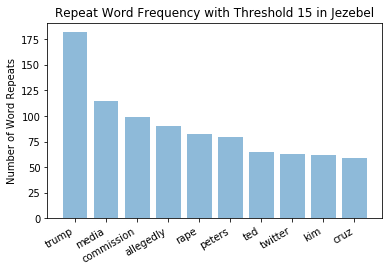

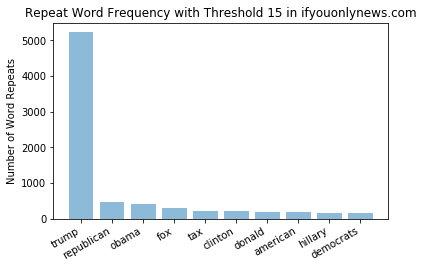

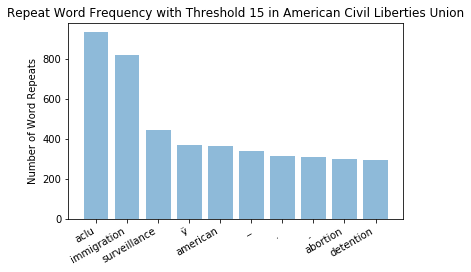

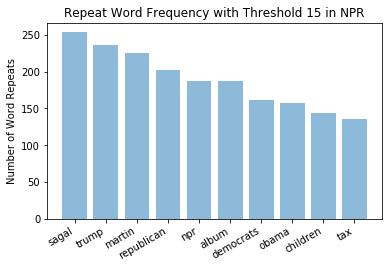

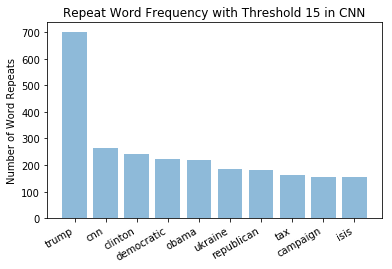

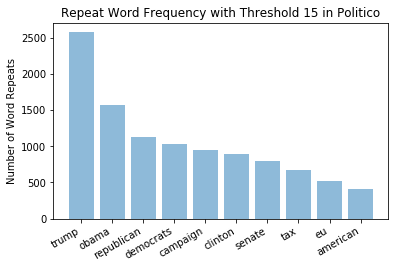

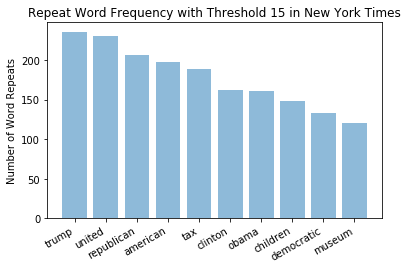

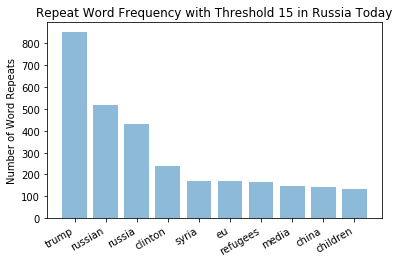

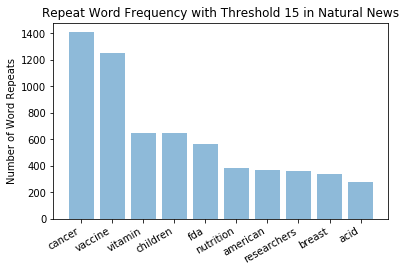

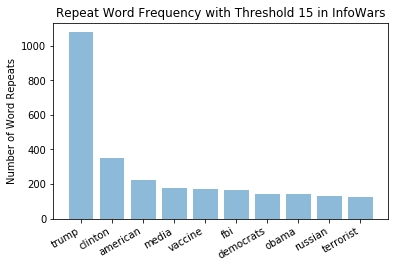

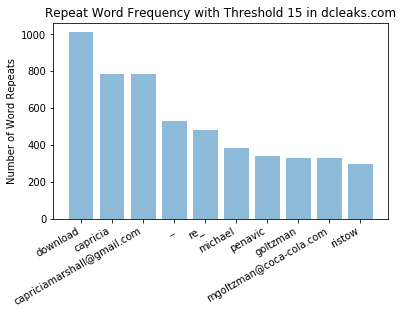

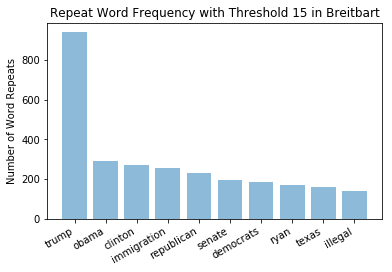

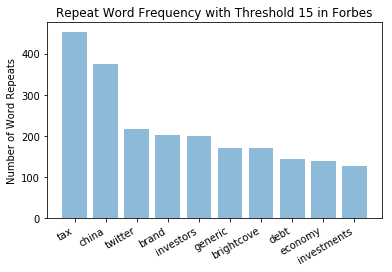

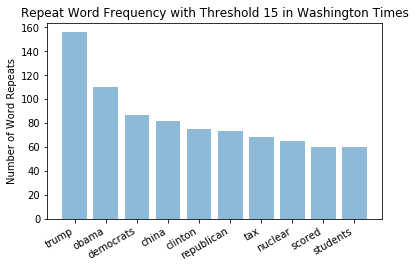

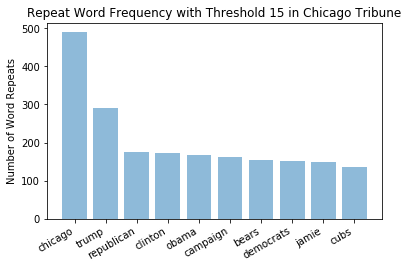

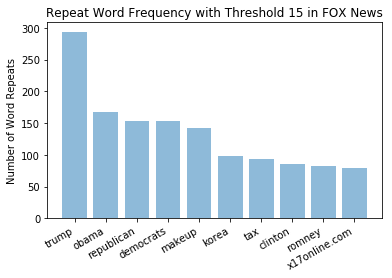

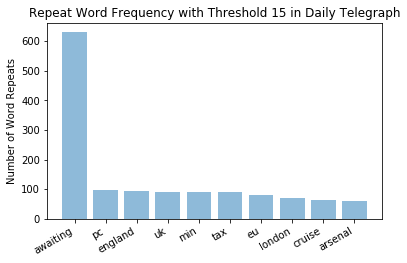

In [42]:
media_names = list(left_fake_media_dict.values())
i = 0
while i < len(left_fake_repeat_words):
    bar_plot_repeat_words(left_fake_repeat_words[i], media_names[i])
    i += 1
    
media_names = list(left_media_dict.values())
i = 0
while i < len(left_repeat_words):
    bar_plot_repeat_words(left_repeat_words[i], media_names[i])
    i += 1
    
media_names = list(right_fake_media_dict.values())
i = 0
while i < len(right_fake_repeat_words):
    bar_plot_repeat_words(right_fake_repeat_words[i], media_names[i])
    i += 1 
    
media_names = list(right_media_dict.values())
i = 0
while i < len(right_repeat_words):
    bar_plot_repeat_words(right_repeat_words[i], media_names[i])
    i += 1
    

(1)

Repeat words for individual articles can help us find interesting content (and connections) to other articles for identifying smaller cliques and trends. But what if we want to find the most popular words per media source? We define a function to do this below.

In [43]:
def get_popular_words(media_id, sample_size, word_num, num_times): 
    """
    Args: media_id: media_id of a media_source
          sample_size: number of sentences to sample
          word_num: number of top words to retain for averaging in each run
          num_times: number of times to run the function and return average counts for the top 'word_num' words
          
    Returns: Most popular words used by the entire media source on average
    """
    popular_words = collections.Counter()
    word_count_call = "https://api.mediacloud.org/api/v2/wc/list"
    params = {'q': media_id, 'sample_size': 3500, 'key': MY_API_KEY}
    
    for _ in range(num_times):
        r = requests.get(word_count_call, params = params, headers = { 'Accept': 'application/json' })
        data = r.json()
    
        for i in range(word_num): 
            popular_words[data[i]['stem']] += data[i]['count']
    
    for word in popular_words:
        popular_words[word] /= num_times
        
    
    return popular_words 


In [44]:
def bar_plot_popular_words(popular_words, media_name):
    popular_words = sorted(popular_words.items(), key=operator.itemgetter(1), reverse=True)
    interesting_words_and_counts = popular_words[:10]
    interesting_words = [i[0] for i in interesting_words_and_counts]
    popular_count = [i[1] for i in interesting_words_and_counts]
    x_pos = range(len(interesting_words))

    fig, ax = plt.subplots()
    ax.bar(x_pos, popular_count, align='center', alpha=0.5)
    plt.xticks(x_pos, interesting_words)
    plt.ylabel("Number of Word Repeats")
    plt.title("Popular Word Frequency in {}".format(media_name))
    fig.autofmt_xdate()
    plt.show()

Let's take a look at some of our most popular words for each media source!

In [45]:
for media_id in left_fake_media_dict:
    popular_words = get_popular_words(media_id, 3500, 20, 3)
    bar_plot_popular_words(popular_words, left_fake_media_dict[media_id])
#     print ("Popular words for {}\n\n{}\n\n".format(left_fake_media_dict[media_id], popular_words))

for media_id in left_media_dict:
    popular_words = get_popular_words(media_id, 3500, 20, 3)
    bar_plot_popular_words(popular_words, left_media_dict[media_id])
#     print ("Popular words for {}\n\n{}\n\n".format(left_media_dict[media_id], popular_words))
    
for media_id in right_fake_media_dict:
    popular_words = get_popular_words(media_id, 3500, 20, 3)
    bar_plot_popular_words(popular_words, right_fake_media_dict[media_id])
#     print ("Popular words for {}\n\n{}\n\n".format(right_fake_media_dict[media_id], popular_words))
    
for media_id in right_media_dict:
    popular_words = get_popular_words(media_id, 3500, 20, 3)
    bar_plot_popular_words(popular_words, right_media_dict[media_id])
#     print ("Popular words for {}\n\n{}\n\n".format(right_media_dict[media_id], popular_words))

ValueError: Expecting value: line 1 column 1 (char 0)

To have a better look at context for each media source, let's take some sentences these popular words are a part of and examine their surrounding words.

In [ ]:
def get_word_count_within_media(media_id, word, num_words=50, sample_size=1000): 
    """
    Args: media_id: ID of media_source to grab word count of interesting words for. 
    """
    params = {'num_words': num_words, 'sample_size': sample_size, 'include_stats': 1, 
              'q': 'media_id: {} AND {}'.format(media_id, word), 'key': MY_API_KEY}
    word_count_call = 'https://api.mediacloud.org/api/v2/wc/list'
    r = requests.get(word_count_call, params = params, headers = { 'Accept': 'application/json'} )
    data = r.json()
    return data

In [ ]:
# random_interesting_words = ['Trump', 'Obama', 'fake news', 'terrorist', 'Kavanaugh', 'midterm', 'Republican', 'Democrat', 'election',
#                      'Russia', 'Jeff Sessions', 'Attorney General', 'tolerance', 'racism', 'sexism', 'gender', 'snowflake',
#                      'shooting', 'massacre', 'guns', 'abortion', 'radical', 'leftwing', 'rightwing', 'queer', 'gay', 'religion',
#                      'healthcare', 'universal', 'immigrant', 'refugee', 'Syria', 'education', 'Beto Rourke']

In [ ]:
interesting_words = []

In [ ]:
for media_id in left_fake_media_dict:
    for word in interesting_words:
        print ("\n\nWords in sentences from {} that contain the popular word:{}\n\n".format(left_fake_media_dict[media_id], word))
        data = get_word_count_within_media(media_id, word)
        print (data)

for media_id in left_media_dict:
    for word in interesting_words:
        print ("\n\nWords in sentences from {} that contain the popular word:{}\n\n".format(left_media_dict[media_id], word))
        data = get_word_count_within_media(media_id, word)
        print (data)  
        
for media_id in right_fake_media_dict:
    for word in interesting_words:
        print ("\n\nWords in sentences from {} that contain the popular word:{}\n\n".format(right_fake_media_dict[media_id], word))
        data = get_word_count_within_media(media_id, word)
        print (data)
        
for media_id in right_media_dict:
    for word in interesting_words:
        print ("\n\nWords in sentences from {} that contain the popular word:{}\n\n".format(right_media_dict[media_id], word))
        data = get_word_count_within_media(media_id, word)
        print (data)

Notes from a quick glance: 
- The word 'media' is mentioned a lot more alongside 'Trump' in right wing and extreme right wing, fake news sources.
- Will find more later - didn't have time to look with more detail

**Important Note**

Before we move on to sentiment analysis and try finding interesting links for our words, we should play around more with the functions above to give us a sense of direction. The setup so far just has a very limited set of media sources and randomly defined interesting words. Even with the provided random words, I haven't run these functions on them(but plan to soon). 

Furthermore, the functions need not run fully sequentially. By that, I mean that certain information can be re-fed in to other functions. I plan on gathering more of the popular words per media source and feeding them in to the word matrix function. I'd be able to the dictionary of article mappings to repeat words that are also popular among the media sources they're a part of. This would allow me - in addition to retrieving the surrounding words in sentences above and conducting sentiment analysis below - have a better context for understanding how media sources with different biases use different words!

## Sentiment Analysis and Interesting Links (Coming with nicer visualizations)

In [ ]:
def analyze_sentiment():
#     Analyze sentiment of word counts for the "interesting sentences" above
    sid = SentimentIntensityAnalyzer()
    for 
